In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
import time
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from functions_file import *
print(testfunction(4))

16


### Outline
1. Import data and add basic information
    1. Import data
    1. Define area & Coarse filtering
    1. Add information
    1. Fine filtering
2. Clean data
2. Look at data
3. Look at diff. modes
6. Check distance and speed values

### 1. Import (cleaned, per polygon, without parking removed) data and add basic information

In [32]:
polygon_name = 'polygon_r11'
polygons = pd.read_csv('../data/polygons11.csv') #polygons11
POLYGON = get_polygon(polygon_name,polygons)
file_name = '../output/data_clean/prepared_data_%s.pkl'%(polygon_name) #change again
file_type = 'pickle'
waypoints_w_dist_mode = import_clean_data(file_name,file_type,polygon_name)

In [36]:
wpwddfs = []
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    polygon_name = 'polygon_r%s'%i
    POLYGON = get_polygon(polygon_name,polygons)
    file_name = '../output/data_clean/prepared_data_%s.pkl'%(polygon_name) #change again
    file_type = 'pickle'
    wpwddfs.append(import_clean_data(file_name,file_type,polygon_name))
all_pol_df = pd.concat(wpwddfs)    

### 2. Clean Data

In [3]:
'''
# remove parking vehicles ##think twice, if we really want this
# definition: parked vehicles = travelled less than 1/10 of the segments length during the whole experiment
group_df = pd.DataFrame()
group_df[['unique_id','d1']] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].max().reset_index()[['unique_id','trv_dist']]
group_df['d0'] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].min().reset_index()['trv_dist']
group_df['ddiff'] = group_df.d1-group_df.d0
display(group_df.head())
cutoff_distance = POLYGON['length']*1000 / 4 #4 or 10
remove = group_df[group_df.ddiff<cutoff_distance].unique_id.values
#waypoints_w_dist_mode = waypoints_w_dist_mode[~waypoints_w_dist_mode.unique_id.isin(remove)]
print('%.1f%% of probes cover less than %s of the %s m'%(100*len(group_df[group_df.ddiff<cutoff_distance])/len(group_df),cutoff_distance,POLYGON['length']*1000))
parked = waypoints_w_dist_mode[waypoints_w_dist_mode.unique_id.isin(remove)]
max_time = pd.DataFrame()
max_time[['unique_id','max_time']] = parked.groupby('unique_id')['time'].max().reset_index()[['unique_id','time']]
max_time['min_time'] = parked.groupby('unique_id')['time'].min().reset_index()['time']
max_time['max_trv'] = parked.groupby('unique_id')['trv_dist'].max().reset_index()['trv_dist']
max_time['min_trv'] = parked.groupby('unique_id')['trv_dist'].min().reset_index()['trv_dist']
max_time['dist_trv'] = max_time['max_trv']-max_time['min_trv']
max_time['speed'] = max_time.dist_trv/(max_time.max_time-max_time.min_time)
plt.scatter(max_time.dist_trv,max_time.max_time-max_time.min_time)
max_time.speed.hist()

#max_dist = parked.groupby('unique_id')['trv_dist'].max()-parked.groupby('trv_dist')['time'].min()
#standstils = parked.groupby('unique_id')['type'].unique().value_counts()
#max_time.hist(bins=45)
'''

"\n# remove parking vehicles ##think twice, if we really want this\n# definition: parked vehicles = travelled less than 1/10 of the segments length during the whole experiment\ngroup_df = pd.DataFrame()\ngroup_df[['unique_id','d1']] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].max().reset_index()[['unique_id','trv_dist']]\ngroup_df['d0'] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].min().reset_index()['trv_dist']\ngroup_df['ddiff'] = group_df.d1-group_df.d0\ndisplay(group_df.head())\ncutoff_distance = POLYGON['length']*1000 / 4 #4 or 10\nremove = group_df[group_df.ddiff<cutoff_distance].unique_id.values\n#waypoints_w_dist_mode = waypoints_w_dist_mode[~waypoints_w_dist_mode.unique_id.isin(remove)]\nprint('%.1f%% of probes cover less than %s of the %s m'%(100*len(group_df[group_df.ddiff<cutoff_distance])/len(group_df),cutoff_distance,POLYGON['length']*1000))\nparked = waypoints_w_dist_mode[waypoints_w_dist_mode.unique_id.isin(remove)]\nmax_time = pd.DataFrame()\nm

In [10]:
'''
#Make line-shapefiles from the dataframe
gdf = parked
def make_lines(point_list):
    if len(point_list)==1:
        return None #Point(point_list)
    else:
        return LineString(point_list)
breakpoint()
line_gdf = gdf.sort_values(by=['time']).groupby(['unique_id'])['geometry'].apply(lambda x:make_lines(x.tolist()))
line_gdf = gpd.GeoDataFrame(line_gdf, geometry='geometry')
line_gdf.crs="EPSG:4326"
line_gdf.to_file('Shapefiles/parked.shp', driver='ESRI Shapefile')
'''

### 3. Look at Data

In [33]:
if type(waypoints_w_dist_mode.iloc[0]['geometry'])==str:
    waypoints_w_dist_mode['geometry'] = waypoints_w_dist_mode['geometry'].apply(lambda x: Point([float(i) for i in x[7:-1].split()]))
waypoints_w_dist_mode = gpd.GeoDataFrame(waypoints_w_dist_mode, geometry=waypoints_w_dist_mode.geometry, crs="EPSG:4326")

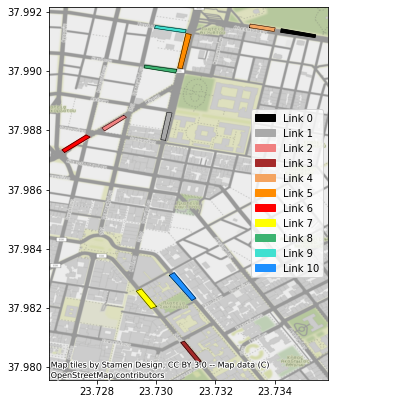

In [147]:
##################
# Plot all polygons with a contextily background map
##################
ax = waypoints_w_dist_mode.iloc[:100,:].plot(figsize=(5, 10), marker='o', color='gray', markersize=1,alpha=0.0)
colors = ['red','darkred','orange','lime','peru','yellow','darkblue',
          'royalblue','skyblue','green','deeppink','lightgreen','thistle','black']
colors2 = ['black','darkgray','lightcoral','brown','white','sandybrown',
           'darkorange','red','yellow','mediumseagreen','turquoise','dodgerblue']
polygons = pd.read_csv('../data/polygons11_vis.csv')
pol_counter= 0
for i,row in polygons.iterrows():
    if (row['name']=='polygon_r4'):# or (row['name']=='polygon_r11'):
        continue
    #i = min(i,10)
    p = get_polygon(row['name'],polygons)
    plt.fill(*p['coords'].exterior.xy,color=colors2[i],label='Link %s'%pol_counter)
    pol_counter+=1
    plt.plot(*p['coords'].exterior.xy,color='black',linewidth=0.5)

# current polygon
plt.legend(loc='right')
#cx.add_basemap(ax, crs=waypoints_w_dist_mode.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, crs = waypoints_w_dist_mode.crs)
#plt.title('Case study area in Athens')
plt.savefig('../output/LinksMap.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
import matplotlib
matplotlib.colors

<module 'matplotlib.colors' from 'C:\\Users\\ga59com\\Anaconda3\\envs\\trb23wC\\lib\\site-packages\\matplotlib\\colors.py'>

In [13]:
'''
Vorgehen:
1. Filtere alle Bus - Medium - Heavy - Taxi Halte heraus
    Lösung: kleiner 1 kmh
2. Matche dort jedem Timestep die entsprechende 5 - Sek - Intervall - Geschwindigkeiten von v_all_MS zu
    Lösung: alle aussortiert, bei denen die mean speed der anderen Fahrzeuge (Car, Motorcycle) unter 10 liegt
3. Sortiere alle weg, bei denen v_all unter einer Schwelle liegt
    Lösung: Schwelle von 10 kmh, bei allem drunter würde es sowieso keinen impact haben
4. Gucke die Haltedauern an
5. Matche die Haltedauern auf die 30 Sekunden-Intervalle
6. Betrachte jeweils die v_all_MS vor, während und nach //v_all_but_bus
'''
print(waypoints_w_dist_mode['type'].unique())
waypoints_w_dist_mode.head(3)

['Car' 'Bus' 'Taxi' 'Motorcycle' 'Medium Vehicle' 'Heavy Vehicle']


,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry
0,1000193,Car,1,Wed,8.5,9.0,2018-10-24,193,60.00,21.0412,418.814283,2018-10-24 08:31:00.000,POINT (23.730327 37.987987)
1,1000193,Car,1,Wed,8.5,9.0,2018-10-24,193,60.16,20.8611,419.719467,2018-10-24 08:31:00.160,POINT (23.730325 37.987979)
2,1000193,Car,1,Wed,8.5,9.0,2018-10-24,193,60.32,20.7354,420.641648,2018-10-24 08:31:00.320,POINT (23.730322 37.987971)


Mean speed of vehicles in stopping intervals before filtering


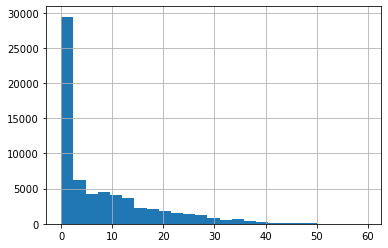

Mean speed of vehicles in stopping intervals after filtering


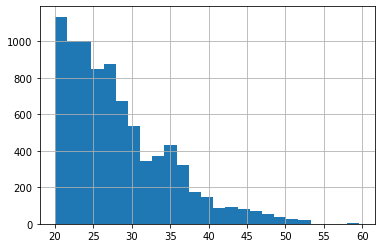

Vehicles stopping, when the mean speed of all vehicles was bigger than 20 km/h:  217
Duration of stops before filtering


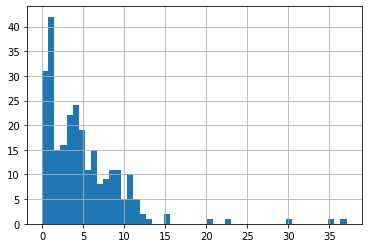

Number of stopped vehicles after filtering by min duration: 28


,unique_id,exp_id,ST,ET,track_id,time,speed,trv_dist,mean_speed,speed_diff,td_val,max_t,min_t,span_per_stop,type
stop_id,,,,,,,,,,,,,,,
112,11000778,11,8.0,8.5,778,232.80,0.0000,0.000000,35.519250,0.0000,True,2018-10-30 08:03:52.800,2018-10-30 08:03:15.680,37.12,Heavy Vehicle
110,11000778,11,8.0,8.5,778,152.32,0.0000,0.000000,35.396020,0.0000,True,2018-10-30 08:02:32.320,2018-10-30 08:01:56.800,35.52,Heavy Vehicle
150,13004126,13,9.0,9.5,4126,495.92,0.8475,501.685880,23.784000,0.8475,True,2018-10-30 09:08:15.920,2018-10-30 09:07:46.160,29.76,Taxi
18,2004418,2,9.0,9.5,4418,379.20,0.0000,175.535997,33.883817,0.0000,True,2018-10-24 09:06:19.200,2018-10-24 09:05:56.640,22.56,Taxi
238,19009359,19,9.5,10.0,9359,783.76,0.9288,159.291665,52.988650,0.0000,False,2018-11-01 09:43:03.760,2018-11-01 09:42:43.440,20.32,Taxi


In [74]:
#########################################
#Specify values:
speed_threshold = 1 #km/h
min_mean_speed = 20 #15 km/h
min_diff_between_timestamps = '2s' #has to be a string
min_duration_of_stops = 10 #5 seconds

#filter for speed < speed_threshold
data = waypoints_w_dist_mode[(waypoints_w_dist_mode.speed<speed_threshold)]
#calculate mean speed for each timestep, merge the mean speed to each datapoint
mspd = pd.DataFrame(waypoints_w_dist_mode[waypoints_w_dist_mode['type'].isin(['Car','Motorcycle'])]
                    .groupby('timestamp')['speed'].mean()).reset_index().rename(columns={'speed':'mean_speed'})
data = data.join(mspd.set_index('timestamp'), on=data['timestamp'])
#filter for vehicle types
spvec_stops = data[(data['type'].isin(['Bus','Taxi', 'Medium Vehicle', 'Heavy Vehicle']))]
print('Mean speed of vehicles in stopping intervals before filtering')
plt.show(spvec_stops.mean_speed.hist(bins=25))
#filter for timesteps, where the mean speed > min_mean_speed
spvec_stops = spvec_stops[spvec_stops.mean_speed>min_mean_speed]
print('Mean speed of vehicles in stopping intervals after filtering')
plt.show(spvec_stops.mean_speed.hist(bins=25))
print('Vehicles stopping, when the mean speed of all vehicles was bigger than %s km/h: '%min_mean_speed, str(len(spvec_stops.unique_id.unique())))

# Calculate speed differences for every time step, calculate timestamp difference for all ids beneath the threshold
# Where the time diff is bigger than 'min_diff_between_timestamps' second, a new stop id is appended

spvec_stops['speed_diff'] = spvec_stops.groupby('unique_id')['speed'].diff()
spvec_stops['time_diff'] = spvec_stops.groupby('unique_id')['timestamp'].diff()
spvec_stops['td_val'] = spvec_stops['time_diff'] > min_diff_between_timestamps # min difference in consecutive timestamps to be counted as new stop
unique_stop_id = 0
stop_ids = []
for i,row in spvec_stops.iterrows():
    if pd.isnull(row['time_diff']) or row['td_val']:
        unique_stop_id += 1
    stop_ids.append(unique_stop_id)
spvec_stops['stop_id'] = stop_ids

#calculate duration of stops, filter for minimum 'min duration of stop' second-stops

aggr = spvec_stops.groupby('stop_id').max('timestamp')
aggr['max_t'] = spvec_stops.groupby('stop_id')['timestamp'].max()
aggr['min_t'] = spvec_stops.groupby('stop_id')['timestamp'].min()
aggr['span_per_stop'] = (aggr['max_t']-aggr['min_t'])/np.timedelta64(1, 's')
aggr['type'] = spvec_stops.groupby('stop_id')['type'].apply(lambda x: list(np.unique(x))[0])
print('Duration of stops before filtering')
plt.show(aggr['span_per_stop'].hist(bins=50))
aggr = aggr[aggr.span_per_stop>min_duration_of_stops]     #min duration of stop
print('Number of stopped vehicles after filtering by min duration: %s'%len(aggr))
aggr.sort_values(by='span_per_stop', ascending=False).head(5)

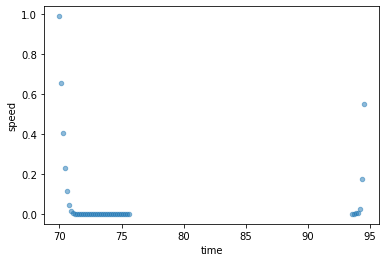

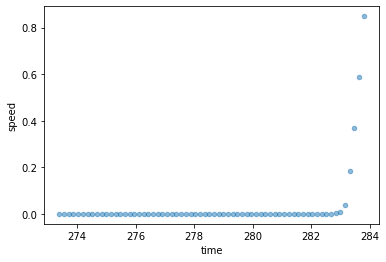

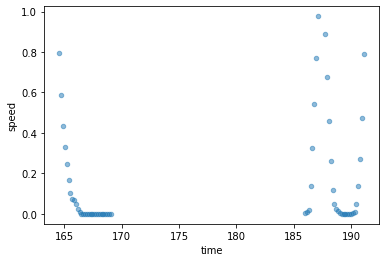

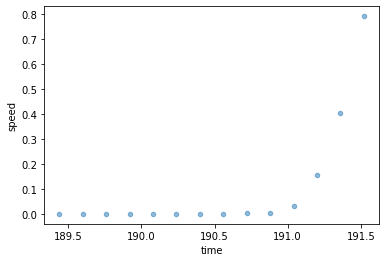

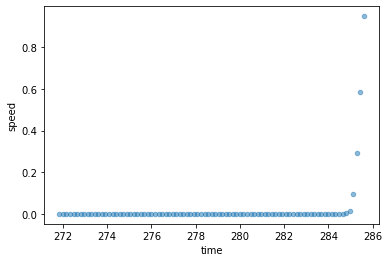

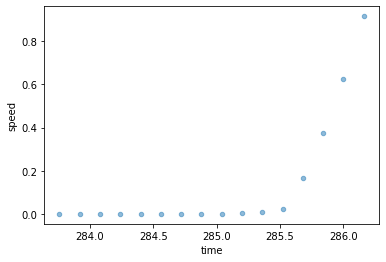

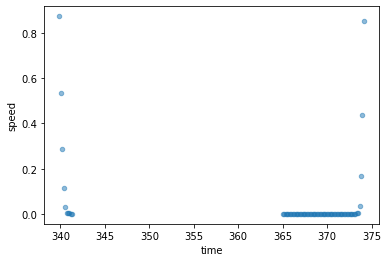

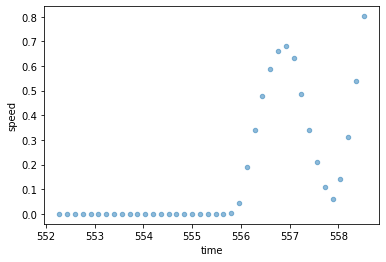

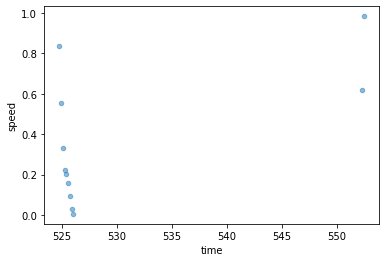

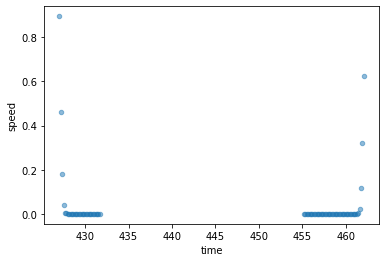

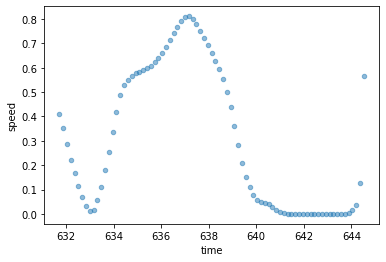

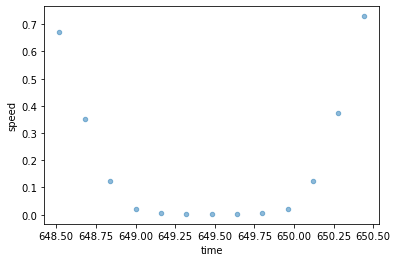

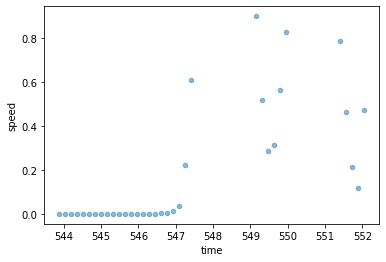

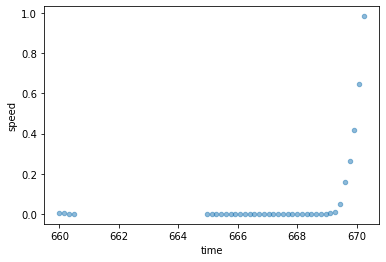

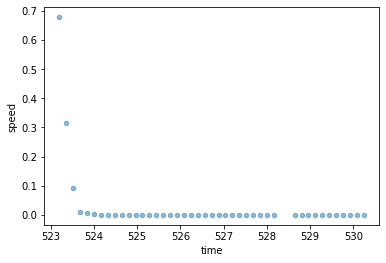

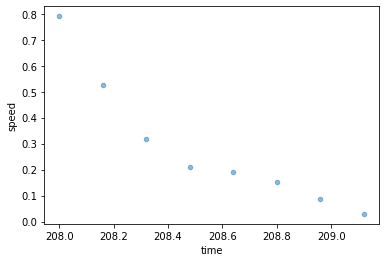

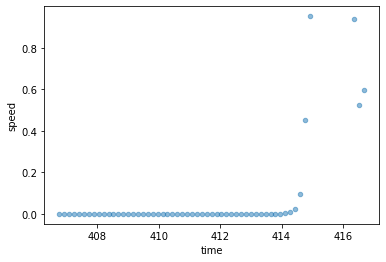

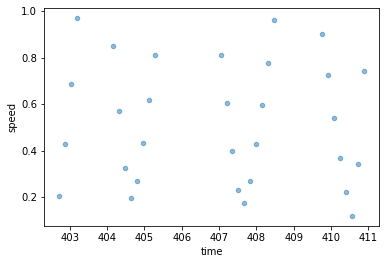

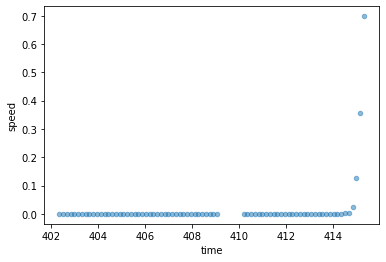

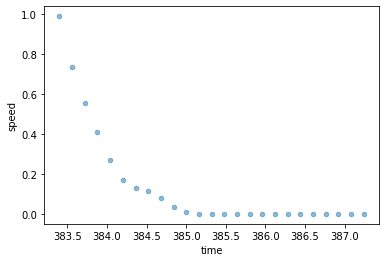

In [84]:
'''
visualize the stops per vehicle:
for unid in spvec_stops.unique_id.unique()[:20]:
    temp = spvec_stops[spvec_stops.unique_id==unid]
    temp.plot.scatter(x="time", y="speed", alpha=0.5)
'''

In [75]:
#plot the location of the stops on a map (in a shapefile)
only_rel_spvec_stop = spvec_stops[spvec_stops.stop_id.isin(aggr.index)]
aggr_geometry = only_rel_spvec_stop.groupby('stop_id').first()
#aggr_geometry = spvec_stops[spvec_stops.unique_id.isin(aggr.unique_id.unique())].groupby('stop_id').first()
#type(aggr_geometry)
aggr_geometry[['type','geometry']].to_file('../output/shapefiles/%s_stops_%skmh_%ssec.shp'%(polygon_name,min_mean_speed,min_duration_of_stops), driver='ESRI Shapefile')


In [48]:
len(aggr_geometry) 

249

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


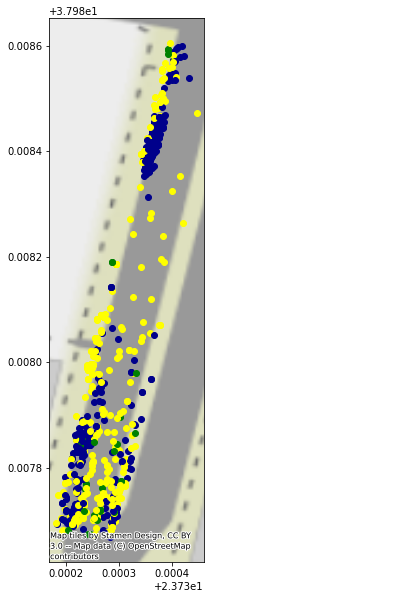

In [31]:
##################
# Plot all polygons with a contextily background map
##################
ax = waypoints_w_dist_mode.iloc[:100,:].plot(figsize=(5, 10), marker='o', color='gray', markersize=1,alpha=0.0)
colors = {'Taxi':'yellow','Medium Vehicle':'green','Heavy Vehicle':'darkblue','Bus':'darkblue'}
polygons = pd.read_csv('../data/polygons11.csv')
for i,row in aggr_geometry.iterrows():
    plt.scatter(row['geometry'].x,row['geometry'].y,color=colors[row['type']])

# current polygon
#plt.legend(loc='lower right')
##cx.add_basemap(ax, crs=waypoints_w_dist_mode.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, crs = waypoints_w_dist_mode.crs)
#plt.title('Vehicle Stops')
##plt.savefig('LinksMap.pdf', format='pdf', dpi=100, bbox_inches='tight')
#plt.show()

In [5]:
# load q,k,v data per interval (30 secs on rolling 3 minutes)
# add scaled up flows and densities

intervals_MS = pd.read_pickle('../output/data_processed/processed_data_all_bypolygon_speed_diff.pkl')
scalefactorsfile = '../output/data_processed/scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'    
# to read
with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)
# test - scale values back up
cs = ['q_all_MS','k_all_MS','q_all_LD','k_all_LD']
#intervals_MS['q_all_LD'] = intervals_MS.q_all
#intervals_MS['k_all_LD'] = intervals_MS.k_all
for c in ['q_all_MS','k_all_MS','q_all_LD','k_all_LD']:
    scaledup = scaleup(intervals_MS[c],intervals_MS['polygon'],scalefactors,c)
    intervals_MS['%s_s'%c] = scaledup
    cs.append('%s_s'%c)
intervals_MS['v2'] = intervals_MS.q_all_LD_s / intervals_MS.k_all_LD_s
intervals_MS.head(3)

,exp_id,polygon,DOW,times,v_Taxi_MS,k_Taxi_MS,q_Taxi_MS,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,...,diff_2_all_MS,diff_3_all_MS,threshold,diff_to_threshold_quantile,density_induced,q_all_MS_s,k_all_MS_s,q_all_LD_s,k_all_LD_s,v2
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,36.983537,0.264116,0.237325,NaN,0.000000,0.000000,...,NaN,NaN,22.218664,21.286990,False,3188.985810,73.300493,2852.251651,40.005692,71.296145
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,42.355535,0.228994,0.231070,45.449044,0.163176,0.180186,...,NaN,NaN,22.218664,22.987365,False,3148.488968,69.779967,4685.841997,57.685940,81.230227
2,1.0,polygon_r0,Wed,2018-10-24 08:32:00,28.237023,0.152663,0.154047,22.724522,0.081588,0.090093,...,-2.799294,NaN,22.218664,18.487695,False,2185.071911,49.234811,3599.269940,44.575028,80.746331


In [6]:
#add the stops to the intervals
start = time.time()
intervals_MS = intervals_MS[intervals_MS.polygon == polygon_name]
intervals_MS['stop_count'] = np.zeros(len(intervals_MS))
intervals_MS['stop_type'] = ['']*len(intervals_MS)
intervals_MS['stop_length'] = ['']*len(intervals_MS)
stop_types = []
# add all columns that matches the stop, vehicles type and duration to the intervals
for i,row in aggr.iterrows():
    t_start_higher_tmin = row['min_t'] < (intervals_MS.times-pd.Timedelta('150s')) #1
    t_start_lower_tmax = row['max_t'] > (intervals_MS.times - pd.Timedelta('150s')) #2
    t_start_lower_tmin = row['min_t'] > (intervals_MS.times-pd.Timedelta('150s')) #3
    t_end_higher_tmin = row['min_t'] < (intervals_MS.times+pd.Timedelta('30s')) #4
    #1+2 oder 3+4
    true = (t_start_higher_tmin & t_start_lower_tmax) | (t_start_lower_tmin & t_end_higher_tmin)
    # additionally add the vehicle type of that stop and the duration
    intervals_MS.stop_count += true
    intervals_MS['new_type'] = np.where(true, row.type, '')
    intervals_MS.stop_type= intervals_MS[['stop_type','new_type']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
    intervals_MS['new_length'] = np.where(true, row.span_per_stop, '')
    intervals_MS.stop_length= intervals_MS[['new_length','stop_length']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
intervals_MS['veh_stop_types'] = intervals_MS.stop_type.str.split(',').apply(lambda x: list(filter(lambda num: num != '', x)))
intervals_MS['veh_stop_lengths'] = intervals_MS.stop_length.str.split(',').apply(lambda x: list(filter(lambda num: num != '', x)))
intervals_MS.veh_stop_lengths = intervals_MS.veh_stop_lengths.apply(lambda x: list(map(float,x)))
intervals_MS = intervals_MS.drop(['stop_type','new_type','stop_length','new_length'], axis=1)
print('Dauer: ', (time.time()-start))

Dauer:  36.257378578186035


In [53]:
intervals_MS[[ 'v_all_MS', 'k_all_MS', 'q_all_MS','v_Car_MS', 'k_Car_MS', 'q_Car_MS','q_all_MS_s', 'k_all_MS_s','stop_count', 'veh_stop_types', 'veh_stop_lengths']].corr()

,v_all_MS,k_all_MS,q_all_MS,v_Car_MS,k_Car_MS,q_Car_MS,q_all_MS_s,k_all_MS_s,stop_count
v_all_MS,1.000000,-0.549373,0.324076,0.933584,-0.471750,0.344292,0.324076,-0.549373,-0.267005
k_all_MS,-0.549373,1.000000,0.374351,-0.511319,0.873588,0.205884,0.374351,1.000000,0.221799
q_all_MS,0.324076,0.374351,1.000000,0.218624,0.338818,0.749315,1.000000,0.374351,0.124678
v_Car_MS,0.933584,-0.511319,0.218624,1.000000,-0.493157,0.281399,0.218624,-0.511319,-0.243178
k_Car_MS,-0.471750,0.873588,0.338818,-0.493157,1.000000,0.442115,0.338818,0.873588,0.097097
q_Car_MS,0.344292,0.205884,0.749315,0.281399,0.442115,1.000000,0.749315,0.205884,-0.012849
q_all_MS_s,0.324076,0.374351,1.000000,0.218624,0.338818,0.749315,1.000000,0.374351,0.124678
k_all_MS_s,-0.549373,1.000000,0.374351,-0.511319,0.873588,0.205884,0.374351,1.000000,0.221799
stop_count,-0.267005,0.221799,0.124678,-0.243178,0.097097,-0.012849,0.124678,0.221799,1.000000


In [165]:
'''
#some things for visualization:
intervals_MS.stop_count.value_counts()
#dummy variablen, transformation, 
intervals_MS.stop_count.hist()
clf = linear_model.LinearRegression()
reg = LinearRegression().fit(intervals_MS[['stop_count']], intervals_MS['v_all_MS'])
print(reg.score(intervals_MS[['stop_count']], intervals_MS['v_all_MS']))
print(reg.coef_)
print(reg.intercept_)
'''

0.0    156
1.0    121
2.0     61
3.0     28
4.0     21
5.0     14
6.0      8
8.0      3
7.0      2
Name: stop_count, dtype: int64

## Count lane changes

In [4]:
waypoints_w_dist_mode_c = waypoints_w_dist_mode.copy(deep=True)

In [76]:
waypoints_w_dist_mode = waypoints_w_dist_mode_c.copy(deep=True)

In [34]:
#idea: check when the vehicles cross the middle line (dashed line)
#lanes-file: header are OL(oben links),OR,UR(unten rechts) and UL; every line contains the 4 points, 
#x,y seperated by ,; points separated by a ;
#one line for every lane, starting from the right most lane in driving direction with id=0
t = time.time()
lanes_coords = pd.read_csv('../data/%s_Lanes.csv'%polygon_name,sep=';')
lanes_df = pd.DataFrame(columns = ['lane_coords'])
for id_,lane in lanes_coords.iterrows():
    lanes_df.loc[id_] = Polygon([[float(lane.OL.split(',')[1]),float(lane.OL.split(',')[0])],
                             [float(lane.OR.split(',')[1]),float(lane.OR.split(',')[0])],
                             [float(lane.UR.split(',')[1]),float(lane.UR.split(',')[0])],
                             [float(lane.UL.split(',')[1]),float(lane.UL.split(',')[0])]])
#data_per_lane =  []
waypoints_w_dist_mode['lane_id'] = [-1]*len(waypoints_w_dist_mode)
for id_,lane_polygon in lanes_df.iterrows():
    waypoints_w_dist_mode['lane_id'] = np.where(waypoints_w_dist_mode.geometry.within(lane_polygon['lane_coords']),
                                                id_,waypoints_w_dist_mode['lane_id'])
    print('lane ',id_,' done!')
print('Dauer: ',time.time()-t)
waypoints_w_dist_mode.lane_id.value_counts()

lane  0  done!
lane  1  done!
lane  2  done!
lane  3  done!
lane  4  done!
Dauer:  70.51705384254456


 4    437715
 3    306116
 2    252231
 1    138137
-1     79123
 0     18845
Name: lane_id, dtype: int64

In [100]:
no_lane = waypoints_w_dist_mode[waypoints_w_dist_mode.lane_id==-1]
no_lane.drop(['DOW','track_id','timestamp'],axis=1).to_file('../output/shapefiles/no_lane_r6.shp', driver='ESRI Shapefile')

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


ValueError: Cannot write empty DataFrame to file.

In [35]:
#no_lane = waypoints_w_dist_mode[waypoints_w_dist_mode.lane_id==-1]
#no_lane.drop(['DOW','track_id','timestamp'],axis=1).to_file('../output/shapefiles/no_lane_r6.shp', driver='ESRI Shapefile')
waypoints_w_dist_mode = waypoints_w_dist_mode[waypoints_w_dist_mode.lane_id>-1]
waypoints_w_dist_mode['lane_id_diff'] = waypoints_w_dist_mode.groupby('unique_id')['lane_id'].diff()
waypoints_w_dist_mode['lane_change'] = ((waypoints_w_dist_mode['lane_id_diff'] != 0) & (~(pd.isnull(waypoints_w_dist_mode['lane_id_diff']))))
waypoints_w_dist_mode['lane_change'].value_counts()

False    1146549
True        6495
Name: lane_change, dtype: int64

In [36]:
# lane changes per vehicle id -> leave out motorcycles since they drive only little maintaining of track
changes_per_veh_id = waypoints_w_dist_mode[waypoints_w_dist_mode['type']!='Motorcycle'].groupby('unique_id')['lane_change'].sum()
#changes_per_veh_id_wM = waypoints_w_dist_mode.groupby('unique_id')['lane_change'].sum()
#changes_per_veh_id = changes_per_veh_id[changes_per_veh_id>8]
#many_changes = waypoints_w_dist_mode[waypoints_w_dist_mode.unique_id.isin(changes_per_veh_id.keys())]
#print(changes_per_veh_id_wM.value_counts())
val_counts_lc = changes_per_veh_id.value_counts()
changes_per_veh_id.value_counts()

0     4750
1     1371
3      239
2      239
4       59
5       34
6       17
7       16
8       12
11       4
10       4
12       3
9        2
15       1
13       1
Name: lane_change, dtype: int64

In [37]:
for x,f in val_counts_lc.items():
    print(x,',',f)

0 , 4750
1 , 1371
3 , 239
2 , 239
4 , 59
5 , 34
6 , 17
7 , 16
8 , 12
11 , 4
10 , 4
12 , 3
9 , 2
15 , 1
13 , 1


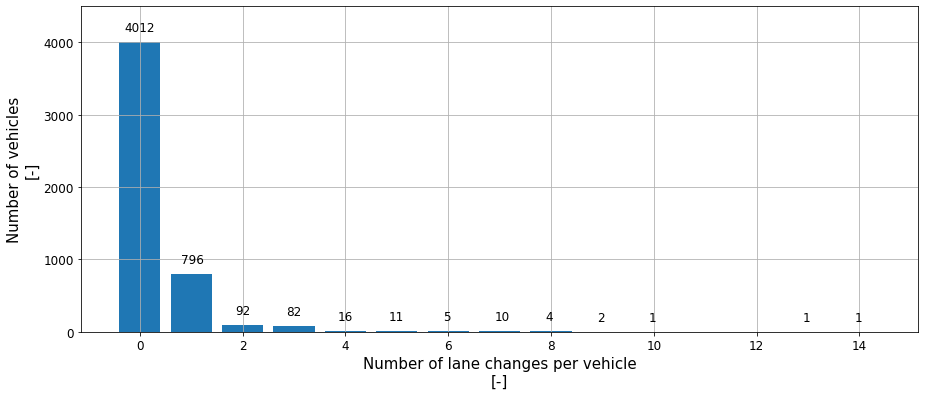

In [148]:
fig, ax = plt.subplots(1,figsize=(15, 6))
#first plot
ax.ticklabel_format(style = 'plain')
#ax.set_title("A - Share of vehicle types",fontsize=15)
ax.bar(val_counts_lc.index, val_counts_lc)
ax.set_ylabel("Number of vehicles\n[-]", fontsize=15)
ax.set_xlabel("Number of lane changes per vehicle\n[-]", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim([-10,4500])
for x,f in val_counts_lc.items():
    if f>1000:
        i = x-0.3
    elif f>100:
        i = x-0.2
    elif f>10:
        i = x-0.15
    else:
        i = x-0.1
    ax.text( i, f+150,str(f), fontsize = 12)
ax.grid()
plt.savefig('../lanechanges_bar.png')

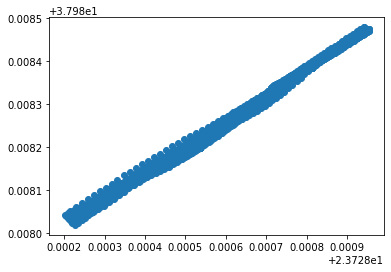

In [32]:
# plt.scatter(many_changes.geometry.x,many_changes.geometry.y)
# Thermik kritisch - wenig steuerbar
# Personal von Autobahn bereit



In [18]:
many_changes['geometry'].to_file('../output/shapefiles/much_changes_lane_r6.shp', driver='ESRI Shapefile')

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [58]:
#Set lane changes per vehicle and interval
# keep for every vehicle the first timestamp where the lane change took place
l_c = waypoints_w_dist_mode[waypoints_w_dist_mode.lane_change]
l_c = l_c[l_c['type']!='Motorcycle'].groupby('unique_id').first()
#add the stops to the intervals
start = time.time()
intervals_MS['lane_changes'] = np.zeros(len(intervals_MS))
# add all columns that matches the stop, vehicles type and duration to the intervals
for i,row in l_c.iterrows():
    t_start_lower_timestamp = row['timestamp'] > (intervals_MS.times-pd.Timedelta('150s')) #1
    t_end_higher_timestamp = row['timestamp'] < (intervals_MS.times+pd.Timedelta('30s')) #2
    #1+2
    true = (t_start_lower_timestamp & t_end_higher_timestamp)
    # additionally add the vehicle type of that stop and the duration
    intervals_MS.lane_changes += true
print('Dauer: ', (time.time()-start))

Dauer:  0.8642327785491943


In [46]:
intervals_MS.columns

Index(['exp_id', 'polygon', 'DOW', 'times', 'v_Taxi_MS', 'k_Taxi_MS',
       'q_Taxi_MS', 'v_Car0050_MS', 'k_Car0050_MS', 'q_Car0050_MS', 'v_Car_MS',
       'k_Car_MS', 'q_Car_MS', 'v_Heavy Vehicle_MS', 'k_Heavy Vehicle_MS',
       'q_Heavy Vehicle_MS', 'v_all_MS', 'k_all_MS', 'q_all_MS',
       'v_Medium Vehicle_MS', 'k_Medium Vehicle_MS', 'q_Medium Vehicle_MS',
       'v_Bus_MS', 'k_Bus_MS', 'q_Bus_MS', 'v_Motorcycle_MS',
       'k_Motorcycle_MS', 'q_Motorcycle_MS', 'lanes', 'direction', 'busstops',
       'seplane', 'length', 'complexity', 'road_rank', 'v_all_LD', 'k_all_LD',
       'q_all_LD', 'diff_1_all_MS', 'diff_2_all_MS', 'diff_3_all_MS',
       'threshold', 'diff_to_threshold_quantile', 'density_induced',
       'q_all_MS_s', 'k_all_MS_s', 'q_all_LD_s', 'k_all_LD_s', 'v2',
       'stop_count', 'veh_stop_types', 'veh_stop_lengths', 'lane_changes'],
      dtype='object')

In [59]:
intervals_MS[[ 'v_all_MS', 'k_all_MS', 'q_all_MS','v_Car_MS','k_Car_MS', 'q_Car_MS','density_induced','stop_count', 'lane_changes']].corr()

,v_all_MS,k_all_MS,q_all_MS,v_Car_MS,k_Car_MS,q_Car_MS,density_induced,stop_count,lane_changes
v_all_MS,1.000000,-0.549373,0.324076,0.933584,-0.471750,0.344292,-0.446737,-0.267005,-0.188251
k_all_MS,-0.549373,1.000000,0.374351,-0.511319,0.873588,0.205884,0.494650,0.221799,0.227718
q_all_MS,0.324076,0.374351,1.000000,0.218624,0.338818,0.749315,-0.109479,0.124678,0.250068
v_Car_MS,0.933584,-0.511319,0.218624,1.000000,-0.493157,0.281399,-0.386121,-0.243178,-0.196159
k_Car_MS,-0.471750,0.873588,0.338818,-0.493157,1.000000,0.442115,0.455468,0.097097,0.212859
q_Car_MS,0.344292,0.205884,0.749315,0.281399,0.442115,1.000000,-0.091216,-0.012849,0.173595
density_induced,-0.446737,0.494650,-0.109479,-0.386121,0.455468,-0.091216,1.000000,0.080084,-0.048335
stop_count,-0.267005,0.221799,0.124678,-0.243178,0.097097,-0.012849,0.080084,1.000000,0.361951
lane_changes,-0.188251,0.227718,0.250068,-0.196159,0.212859,0.173595,-0.048335,0.361951,1.000000


In [ ]:
'''

filename_lc = '../output/shapefiles/r6_no_lanechanges.shp'
make_shape_from_line_trajectories(many_changes,filename_lc)

filename_lc = '../output/shapefiles/r6_no_lanechanges.shp'
make_shape_from_line_trajectories(many_changes,filename_lc)
for i in range(0,3):
    waypoints_w_dist_mode[waypoints_w_dist_mode.lane_id==i]drop(['DOW','track_id','timestamp'],axis=1).to_file(filename_lc, driver='ESRI Shapefile')
#check for better lane identification: distance from road side --> nothing found there
cs = [(0,0), (37.991253,23.731158), (37.990029,23.730857), (0,0)]
distances = get_distance_from_segment_start(waypoints_w_dist_mode,cs)
distances_wo_mot = get_distance_from_segment_start(waypoints_w_dist_mode[waypoints_w_dist_mode['type']!='Motorcycle'],cs)
'''

In [ ]:
#real world data (9 € Studie, TomTom) -> Trainieren auf GPS-Daten + Schleifen
# Übertragung in den Outlook -> Schleifen und Trajektorien

In [ ]:
#Fahrzeuge die im Intervall lane change durchgeführt haben -- check
#events(stops) und lane change: abhängige Variablen
#-> netz trainieren mit bus, taxi, LDD, 5% Cars --> q, k (=regular) lane change, events (=enriched)
# mit drei szenarien durch spielen
#Argument NN: kolinearität

In [60]:
intervals_MS.to_pickle('../output/processed_data_polygon_r6.pkl')##change here

# Code to copy if necessary

In [137]:
x = [37.991268,37.990107,37.991267,37.990097,37.991258,37.990096]
y = [23.731006, 23.73073,23.731085,23.730805,23.731123,23.730832]
points=gpd.GeoDataFrame(geometry=gpd.points_from_xy(y,x))
filename_lanes = '../output/shapefiles/r6_lanes.shp'
points.to_file(filename_lanes, driver='ESRI Shapefile')

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [130]:
lanes_coords

,OL,OR,UR,UL,geometry,ol_point,ul_point
0,"37.991268,23.731006","37.991267, 23.731085","37.990097, 23.730805","37.990107, 23.730730",0.0,"[23.731006, 37.991268]","[23.73073, 37.990107]"
1,"37.991267, 23.731085","37.991258, 23.731123","37.990096, 23.730832","37.990097, 23.730805",0.0,"[23.731085, 37.991267]","[23.730805, 37.990097]"
2,"37.991258, 23.731123","37.991238,23.731186","37.990089, 23.730882","37.990096, 23.730832",0.0,"[23.731123, 37.991258]","[23.730832, 37.990096]"


In [ ]:
# to do: literature review on traffic state estimation approaches with fcd (Felix Rempe Diss)
# Kesting, Arne mal gucken für Literatur-Teil: geben die auch Events aus? Oder Lane Changes?
# Hiwi checken



Nächste steps:
    Netz Trainieren
    Hiwi für Literatur

### 4. Check some mode and speed related stuff

### Look at modal split on diff. links

,polygon,name,p0_lat_frontleft,p0_lon_frontleft,p0_lat_frontright,p0_lon_frontright,p0_lat_backright,p0_lon_backright,p0_lat_backleft,p0_lon_backleft,length,lanes,direction,busstops,seplane,comment,complexity,road_rank
0,0,polygon_r0,37.991314,23.734210,37.991427,23.734227,37.991224,23.735388,37.991136,23.735368,0.1050,3,170,0,1,2 + cab/bus/motorcycle lane,1,0
1,1,polygon_r1,37.987662,23.730315,37.987685,23.730157,37.988612,23.730365,37.988585,23.730539,0.1050,3,255,2,0,,1,0
2,2,polygon_r2,37.988508,23.728905,37.988441,23.729000,37.987979,23.728257,37.988080,23.728166,0.0840,2,35,0,0,,1,0
3,3,polygon_r3,37.980203,23.731516,37.980145,23.731402,37.980831,23.730832,37.980877,23.730955,0.0900,3,310,0,1,2 + cab/bus/motorcycle lane,1,0
4,4,polygon_r4,37.983096,23.730470,37.983160,23.730631,37.979420,23.733781,37.979350,23.733642,0.4990,4,130,0,0,"has traffic lights, one lane in opposite direc...",2,0
5,5,polygon_r5,37.991469,23.733146,37.991589,23.733177,37.991461,23.734021,37.991337,23.733988,0.0750,3,170,0,1,two lanes + bus/motorcycle lane (at peak times...,1,0
6,6,polygon_r6,37.990089,23.730882,37.990107,23.730730,37.991268,23.731006,37.991238,23.731186,0.1305,3,260,0,1,two lanes + bus/motorcycle lane (at peak times...,1,0
7,7,polygon_r7,37.987253,23.726909,37.987339,23.726821,37.987843,23.727636,37.987771,23.727769,0.0950,2,220,0,0,,1,0
8,8,polygon_r8,37.982050,23.730014,37.981978,23.729825,37.982568,23.729328,37.982645,23.729507,0.0790,3,310,1,0,,1,0
9,9,polygon_r9,37.990054,23.730700,37.989937,23.730659,37.990110,23.729593,37.990201,23.729613,0.0930,2,350,1,0,trees affect drone footage,1,1


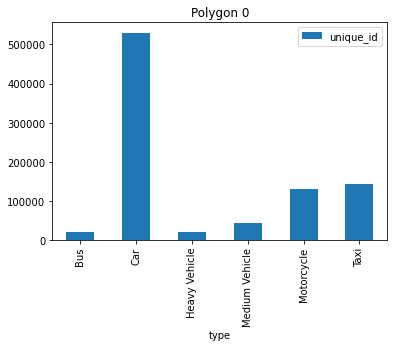

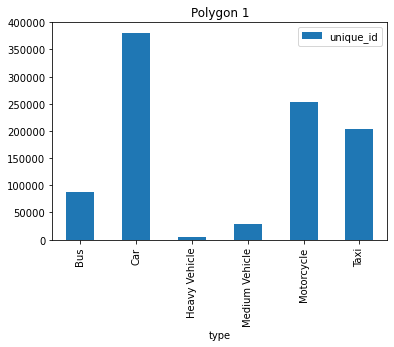

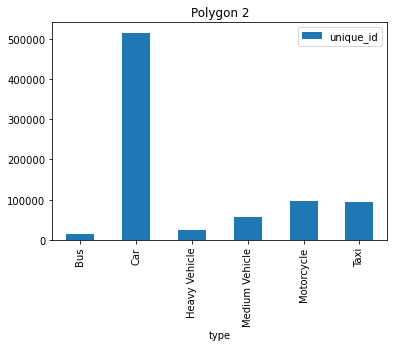

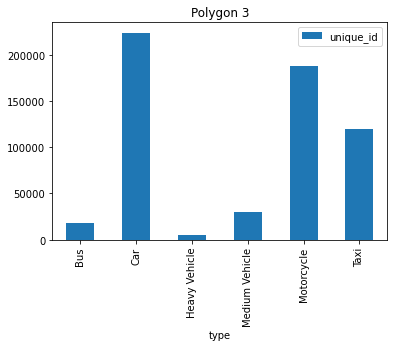

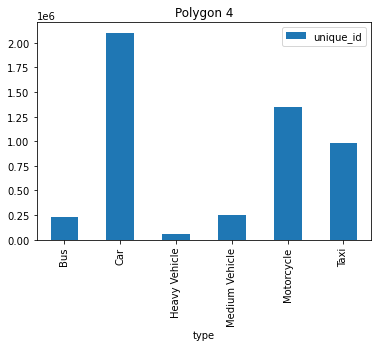

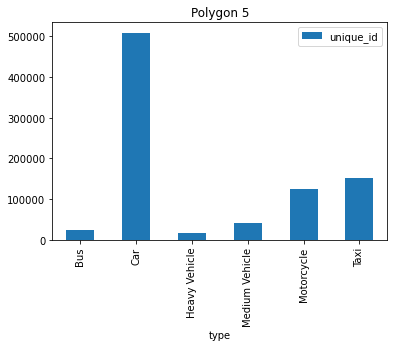

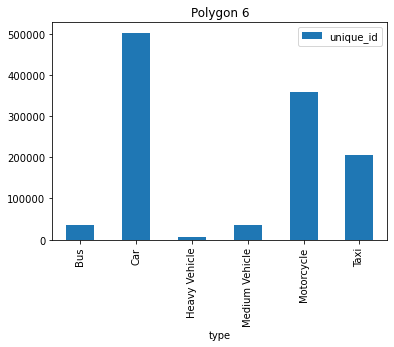

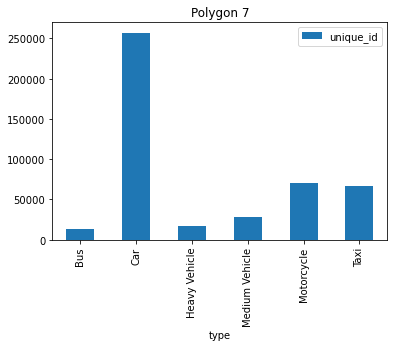

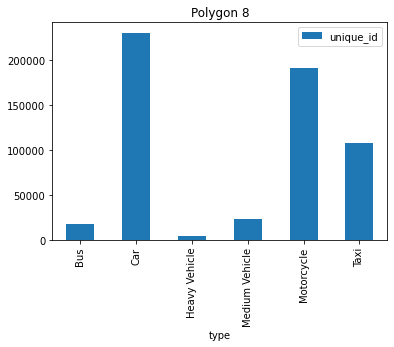

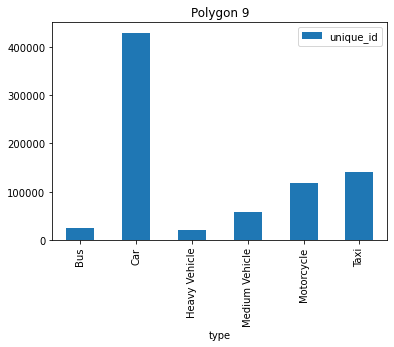

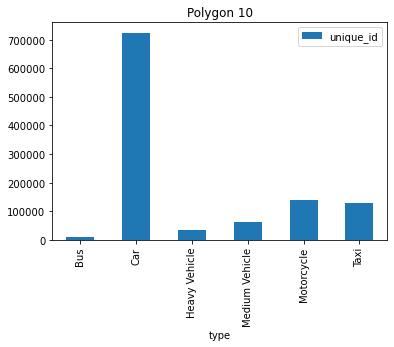

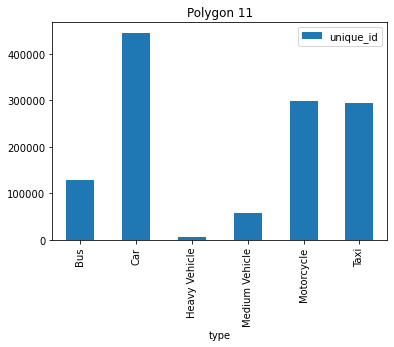

In [28]:
#########################
# CHECK IF ALL SEGMENTS HAVE ALL MODES
#########################

polygons = pd.read_csv('../data/polygons11.csv')
display(polygons)
for n in range(len(polygons)):
    
    #########################
    # choose polygon
    #########################

    POLYGON = polygons[polygons.polygon==n].iloc[0,:].to_dict()
    ps = ['p0_lon_frontleft','p0_lat_frontleft','p0_lon_frontright','p0_lat_frontright',
         'p0_lon_backright','p0_lat_backright','p0_lon_backleft','p0_lat_backleft']
    POLYGON['coords'] = Polygon([[POLYGON[ps[0]],POLYGON[ps[1]]],[POLYGON[ps[2]],POLYGON[ps[3]]],
                                 [POLYGON[ps[4]],POLYGON[ps[5]]],[POLYGON[ps[6]],POLYGON[ps[7]]]])
    [POLYGON.pop(k) for k in ps]
    
    #########################
    # import data
    #########################

    polygon_name = POLYGON['name']
    file_name = '../output/data_clean/prepared_data_%s.pkl'%(polygon_name)
    file_type = 'pickle' # 'csv'
    waypoints_w_dist_mode = import_clean_data(file_name,file_type,polygon_name)
    
    #########################
    # check data
    #########################

    tmp = waypoints_w_dist_mode[['type','unique_id']].groupby(by='type').count()
    tmp['type'] = tmp.index
    tmp.plot.bar(x='type',y='unique_id')
    plt.title('Polygon %i'%(n))
    plt.show()

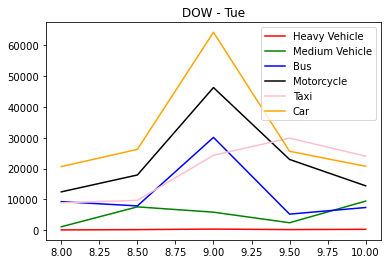

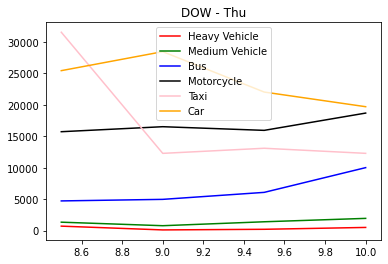

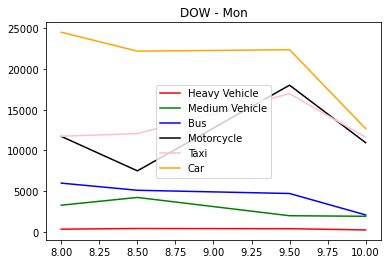

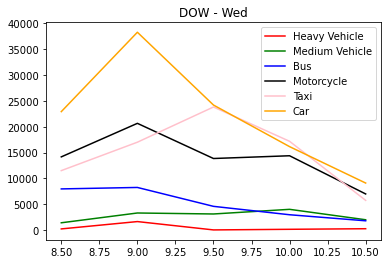

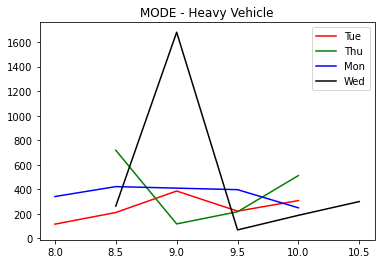

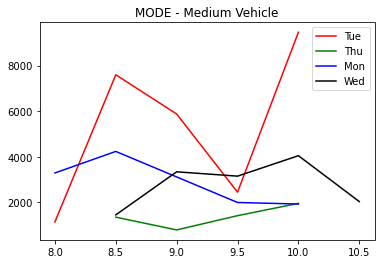

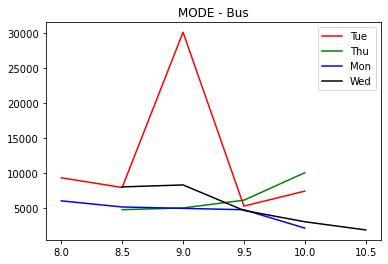

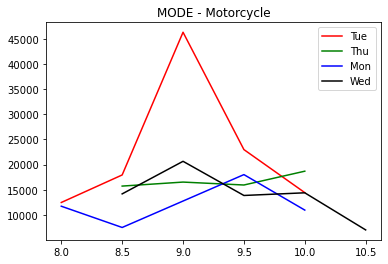

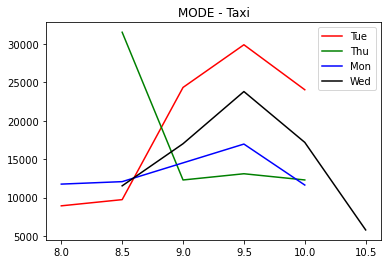

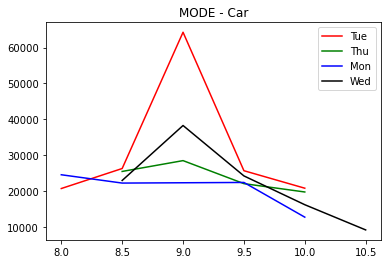

In [29]:
# compare mode % at diff time across weekdays
data = waypoints_w_dist_mode.groupby(['type','DOW','ST'])['time'].count().reset_index() 

##################
# check occurences for diff DOWs / modes / STs
##################

types = set(data.type)
DOWs = set(data.DOW)
coldict_types = dict(zip(types,['red','green','blue','black','pink','orange','purple','lightblue']))
coldict_DOWs = dict(zip(DOWs,['red','green','blue','black']))

# split by DOW
for day in DOWs:
    plt.figure(figsize=(6,4))
    subset = data[(data.DOW==day)]
    for m in types:
        plt.plot(subset[subset.type==m].ST,subset[subset.type==m].time,color=coldict_types[m],label=m)    
    plt.legend()
    plt.title('DOW - %s'%(day))
    plt.show()
    
# split by mode
for m in types:
    plt.figure(figsize=(6,4))
    subset = data[(data.type==m)]
    for day in DOWs:
        plt.plot(subset[subset.DOW==day].ST,subset[subset.DOW==day].time,color=coldict_DOWs[day],label=day)    
    plt.legend()
    plt.title('MODE - %s'%(m))
    plt.show()

### Look at exact trajectories of the different modes

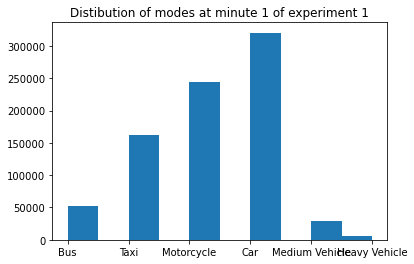

{'Heavy Vehicle', 'Medium Vehicle', 'Bus', 'Motorcycle', 'Taxi', 'Car'}


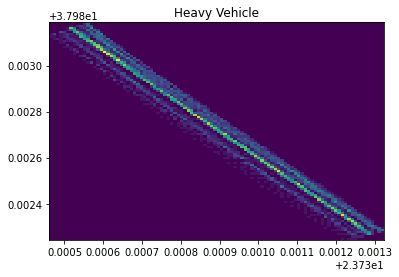

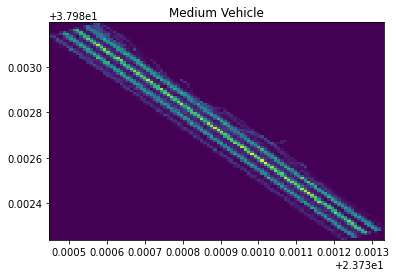

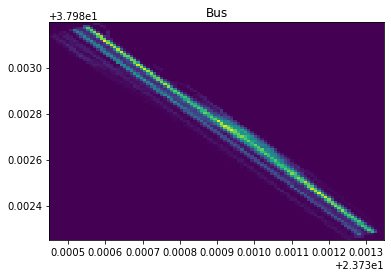

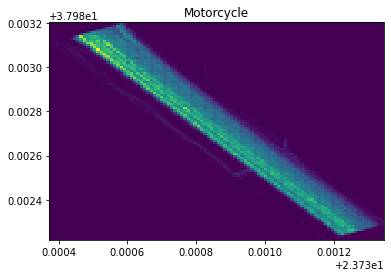

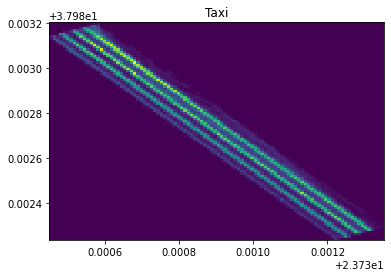

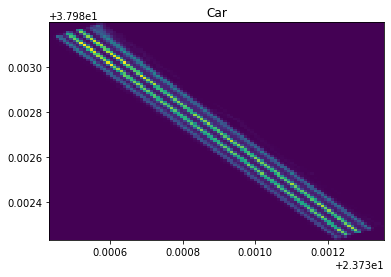

In [30]:
# select subset of data
data = waypoints_w_dist_mode[(waypoints_w_dist_mode.speed>3)]

# check distribution of modes
plt.hist(data['type'])
plt.title('Distibution of modes at minute 1 of experiment 1')
plt.show()

# check 2D histogram by mode 
print(set(data['type']))
for subset in set(data['type']):
    subset_data = data[data['type']==subset]
    _ = plt.hist2d(subset_data.geometry.x,subset_data.geometry.y,bins=100) # h, xedges, yedges, image = 
    plt.title('%s'%(subset))
    plt.show()

### Check speed and distance values

In [31]:
def lat_lon_2_m(latitude_1, longitude_1, latitude_2, longitude_2):
    
    radius_earth = 6371009 # Radius of the earth in m
    d_latitude = np.deg2rad(latitude_2 - latitude_1)
    d_longitude = np.deg2rad(longitude_2 - longitude_1)
    latitude_1 = np.deg2rad(latitude_1)
    latitude_2 = np.deg2rad(latitude_2)
    
    a = (np.sin(d_latitude / 2)) ** 2 + np.cos(latitude_1) * np.cos(latitude_2) * (np.sin(d_longitude / 2)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius_earth * c
    
    return distance

def calculate_distance(latitude, longitude):
    distance = np.zeros(len(latitude))
    for i in range(0, len(latitude) - 1):
        # calc distance between two consecutive points using lat_lon_2_m function
        distance[i + 1] = lat_lon_2_m(latitude[i],longitude[i],latitude[i + 1],longitude[i + 1])
    return distance

def calculate_speed(array_distances,array_deltatime):
    speed = [0] * (len(array_distances)-1)
    for i in range(0, len(array_distances)-1):
        if array_deltatime[i] != 0:
            speed[i] = array_distances[i] / array_deltatime[i] * 3.6
        elif array_distances[i] == 0:
            speed[i] = 0
        else: 
            speed[i] = speed[i-1]
    # Add entry to acceleration, to have same length as speed
    speed = np.append(speed, [0])
    return speed

In [35]:
display(waypoints_w_dist_mode.head(3))

,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry
597,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.40,27.7997,183.360564,2018-10-24 08:37:39.400,POINT (23.73131 37.98228)
598,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.56,27.9001,184.531063,2018-10-24 08:37:39.560,POINT (23.73130 37.98229)
599,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.72,27.9637,185.752482,2018-10-24 08:37:39.720,POINT (23.73130 37.98230)


In [45]:
testdata = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==1)&(waypoints_w_dist_mode.track_id==650)].reset_index()
testdata.geometry.y

0     37.982282
1     37.982291
2     37.982300
3     37.982309
4     37.982319
        ...    
89    37.983131
90    37.983141
91    37.983151
92    37.983161
93    37.983171
Length: 94, dtype: float64

      speed  speed_latlon  speed_trv_dist
89  29.7559     29.577347       29.528950
90  29.7808     29.577346       29.529218
91  29.8457     29.577345       29.529484
92  29.9492     29.577344       29.529745
93  30.0853      0.000000        0.000000


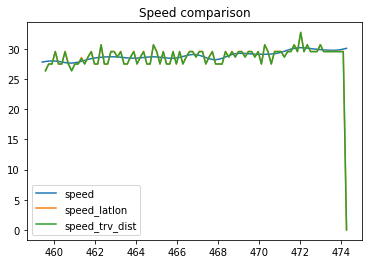

   delta_dist  delta_dist_latlon
0         NaN           0.000000
1    1.170499           1.173842
2    1.221419           1.221936
3    1.221419           1.221936
4    1.311902           1.314553


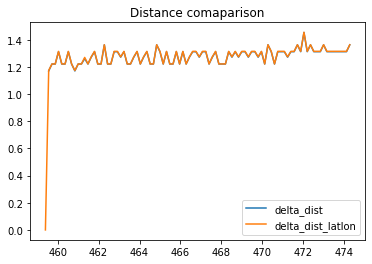

In [46]:
# small subset of data for testing
testdata = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==1)&(waypoints_w_dist_mode.track_id==650)].reset_index()

# calc dist using lat and lon
testdata['delta_dist_latlon'] = calculate_distance(testdata.geometry.y,testdata.geometry.x)#testdata.lat,testdata.lon
testdata['trv_dist_latlon'] = testdata.delta_dist_latlon.cumsum()

# calc deltatime & deltadist
testdata['deltatime'] = testdata.time.diff()
testdata['delta_dist'] = testdata.trv_dist.diff()

# calc speed using lat and lon
testdata['speed_latlon'] = calculate_speed(testdata.delta_dist_latlon,testdata.deltatime)
testdata['speed_trv_dist'] = calculate_speed(testdata.delta_dist,testdata.deltatime)

# check speed plot
print(testdata[['speed','speed_latlon','speed_trv_dist']].tail())
plt.plot(testdata.time,testdata.speed,label='speed')
plt.plot(testdata.time,testdata.speed_latlon,label='speed_latlon')
plt.plot(testdata.time,testdata.speed_trv_dist,label='speed_trv_dist')
plt.legend()
plt.title('Speed comparison')
plt.show()

# check dist plot
print(testdata[['delta_dist','delta_dist_latlon']].head())
plt.plot(testdata.time,testdata.delta_dist,label='delta_dist')
plt.plot(testdata.time,testdata.delta_dist_latlon,label='delta_dist_latlon')
plt.legend()
plt.title('Distance comaparison')
plt.show()

### --> given speed pretty much the same as lat lon speed 

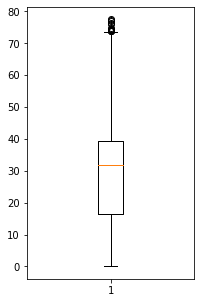

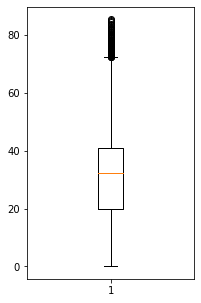

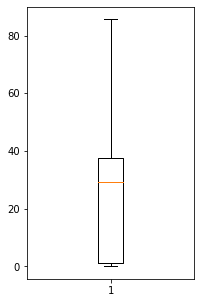

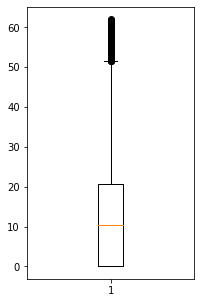

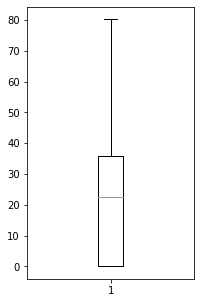

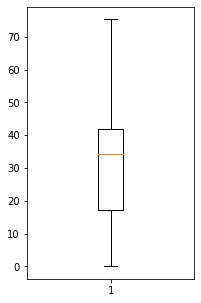

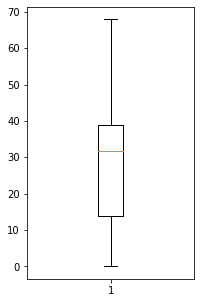

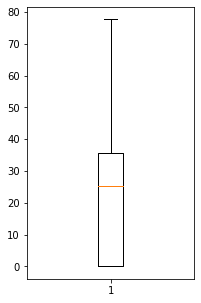

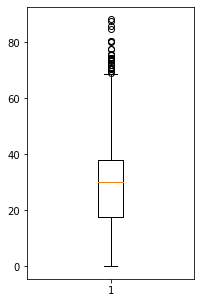

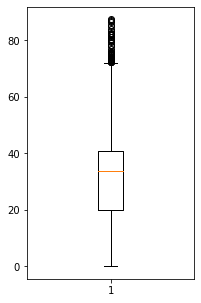

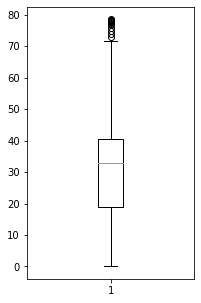

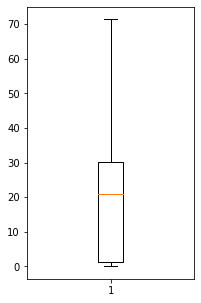

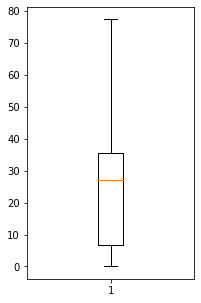

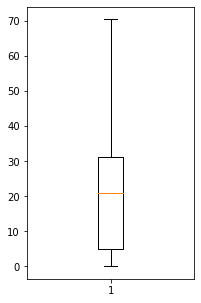

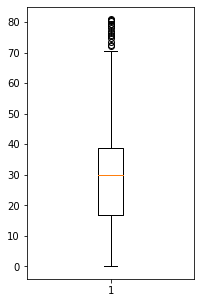

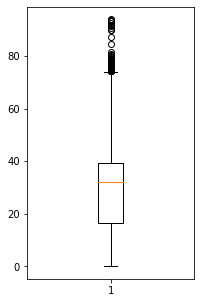

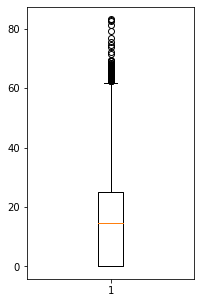

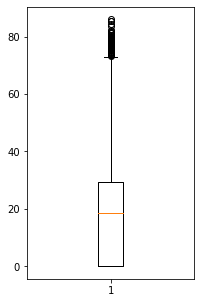

In [40]:
##Unnecessary tryouts

for exp in waypoints_w_dist_mode.exp_id.unique():
    subset = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==exp)]
    plt.figure(figsize=(3,5))
    plt.boxplot(subset.speed)
    #for unid in subset.groupby('unique_id'):
        #plt.plot(unid[1].time, unid[1].speed)
        #plt.boxplot(unid[1].speed)
    
    #plt.plot(subset.time, subset.speed,'.')